In [1]:
from datasets import get_dataset
from synthcity.utils.serialization import save_to_file, load_from_file
from synthcity.plugins import Plugins
from synthcity.benchmark import Benchmarks
from pathlib import Path
import pandas as pd

In [2]:
out_dir = Path("output")
prefix = "detection.detection_mlp"

metrics = [
    "sanity.data_mismatch.score",
    "sanity.common_rows_proportion.score",
    "sanity.nearest_syn_neighbor_distance.mean",
    "sanity.close_values_probability.score",
    "sanity.distant_values_probability.score",
    "stats.jensenshannon_dist.marginal",
    "stats.chi_squared_test.marginal",
    "stats.feature_corr.joint",
    "stats.inv_kl_divergence.marginal",
    "stats.ks_test.marginal",
    "stats.max_mean_discrepancy.joint",
    "stats.wasserstein_dist.joint",
    "stats.prdc.precision",
    "stats.prdc.recall",
    "stats.prdc.density",
    "stats.prdc.coverage",
    "stats.alpha_precision.delta_precision_alpha",
    "stats.alpha_precision.delta_coverage_beta",
    "stats.alpha_precision.authenticity",
    "performance.linear_model.gt",
    "performance.linear_model.syn_id",
    "performance.linear_model.syn_ood",
    "performance.mlp.gt",
    "performance.mlp.syn_id",
    "performance.mlp.syn_ood",
    "performance.xgb.gt",
    "performance.xgb.syn_id",
    "performance.xgb.syn_ood",
    "detection.detection_xgb.mean",
    "detection.detection_mlp.mean",
    "detection.detection_gmm.mean",
    "privacy.delta-presence.score",
    "privacy.k-anonymization.gt",
    "privacy.k-anonymization.syn",
    "privacy.k-map.score",
    "privacy.distinct l-diversity.gt",
    "privacy.distinct l-diversity.syn",
    "privacy.identifiability_score.score",
]


def get_metric(
    dataset: str,
    metric: str,
    models=[
        "baseline_adsgan",
        "baseline_ctgan",
        "baseline_tvae",
        "baseline_privbayes",
        "baseline_nflow",
        "survival_survival_gan",
    ],
):
    results = []
    for name in models:
        bkp = out_dir / f"{prefix}.{dataset}_{name}.bkp"
        df, duration_col, event_col, time_horizons = get_dataset(dataset)

        try:
            score = load_from_file(bkp)
        except BaseException as e:
            print("failed to load file", e)
            continue

        for model in score:
            method_score = score[model]
            local_df = method_score.loc[metric].copy()
            local_df["model"] = model
            results.append(local_df.to_frame().T)

    return pd.concat(results, ignore_index=True)

In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action="once")

# sns.set_style("white")
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, HTML

fontsize = 10
text_kwargs = dict(fontsize=fontsize)

def map_dataset(d):
    if d == "maggic":
        return "pheart"
    
    return d

def generate_plot_for_ax(ax, title, data):
    datasets = data["dataset"].unique()
    datasets_cnt = len(datasets)

    barWidth = 1

    max_val = 0
    idx = 0

    models = [
        "adsgan",
        "ctgan",
        "tvae",
        "privbayes",
        "nflow",
        "survival_gan",
    ]
    cases = [
        ("#30a2da", "adsgan"),
        ("#ff9cde", "ctgan"),
        ("#e5ae38", "tvae"),
        ("#6d904f", "privbayes"),
        ("#8b8b8b", "nflow"),
        ("#D23e4e", "survival_gan"),
    ]
    models_cnt = len(models)

    maxval = 0

    for color, model in cases:
        base_mod_mean = data[data["model"] == model]["mean"]
        base_mod_std = data[data["model"] == model]["std"]
        if len(base_mod_mean) == 0:
            print("invalid model", model)
            continue

        edgecolor = "k"

        idxs = [
            (idx + ((models_cnt + 1) * r)) * barWidth for r in range(len(base_mod_mean))
        ]
        ax.bar(
            idxs,
            base_mod_mean.values,
            yerr=base_mod_std.values,
            width=barWidth,
            label=model,
            edgecolor=edgecolor,
            color=color,
        )

        maxval = max(maxval, max((base_mod_mean + base_mod_std).values))
        idx += 1

    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.2),
        ncol=models_cnt,
        prop={"size": fontsize},
    )

    pretty_data = [map_dataset(d) for d in datasets]
    
    ax.set_xticks(
        [(models_cnt + 1) * r + int(models_cnt / 2) for r in range(datasets_cnt)],
        pretty_data,
        rotation=0,
        fontsize=fontsize,
    )
    
    #ax.set_yticks([0.2 * v for v in range(int(10 * maxval) + 2)], fontsize=100)
    ax.set_ylabel(title, fontsize=fontsize)

    ax.tick_params(axis="both", which="major", labelsize=fontsize)

    return ax


def generate_plot(title, data):
    # ['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast',
    #'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']

    plt.style.use("seaborn-whitegrid")

    offset = len(data)
    fig, axs = plt.subplots(1, figsize=(3 * len(data["dataset"].unique()), 3))

    generate_plot_for_ax(axs, title, data)

    plt.subplots_adjust(hspace=0.35)
    plt.savefig(f"diagrams/metrics_{title}.png")
    plt.savefig(f"diagrams/metrics_{title}.pdf")
    plt.show()


def print_performance_table(title, df, datasets):
    str_repr = [
        f"{round(m, 4)} +/- {round(s, 4)}"
        for m, s in zip(df["mean"].values, df["std"].values)
    ]
    df["str"] = str_repr
    df = df.drop(columns=["mean", "std"])

    piv = df.pivot_table(
        values="str", index=df["model"], columns="dataset", aggfunc="first"
    )
    display(piv[datasets])

def extract_performance(
    datasets: list, title: str, metrics: list, direction: str = "maximize"
):
    headers = ["model", "mean", "std", "dataset"]
    res_df = pd.DataFrame([], columns=headers)

    for dataset in datasets:
        results = []

        for metric in metrics:
            try:
                local_metrics = get_metric(dataset, metric)

                results.append(local_metrics.reset_index(drop=True))
            except BaseException as e:
                raise
                print("get metric failed", e)
                continue

        if len(results) == 0:
            continue

        for idx, row in results[0].iterrows():
            local_results = pd.concat(
                [v.iloc[idx].to_frame().T for v in results], ignore_index=True
            )

            if direction == "maximize":
                best_result = local_results[
                    local_results["mean"] == local_results["mean"].max()
                ]
            elif direction == "minimize":
                best_result = local_results[
                    local_results["mean"] == local_results["mean"].min()
                ]
            else:
                raise RuntimeError(f"invalid direction {direction}")

            local_df = pd.DataFrame(
                [
                    [
                        best_result["model"].values[0],
                        best_result["mean"].values[0],
                        best_result["stddev"].values[0],
                        dataset,
                    ]
                ],
                columns=headers,
            )
            res_df = pd.concat([res_df, local_df], ignore_index=True)

    return res_df

def plot_performance(
    datasets: list, title: str, metrics: list, direction: str = "maximize"
):
    res_df = extract_performance(datasets, title, metrics, direction)
    
    print("Scenario", title)
    print_performance_table(title, res_df, datasets)
    generate_plot(title, res_df)

    print("=" * 100)
    return res_df

def plot_performance_with_baseline(
    datasets: list, title: str, metrics: list, baseline_metrics: list,  direction: str = "maximize"
):
    res_df = extract_performance(datasets, title, metrics, direction)
    res_base_df = extract_performance(datasets, title, baseline_metrics, direction)
    
    print("Scenario", title, res_base_df)
    print_performance_table(title, res_df, datasets)
    generate_plot(title, res_df)

    print("=" * 100)
    return res_df

## Metrics

Scenario Maximum mean discrepancy


dataset,aids,cutract,maggic
model,,,
adsgan,0.0686 +/- 0.0247,0.0581 +/- 0.0029,0.0194 +/- 0.0104
ctgan,0.0336 +/- 0.0125,0.1504 +/- 0.0078,0.0015 +/- 0.0003
nflow,0.0857 +/- 0.0022,0.2983 +/- 0.0232,0.004 +/- 0.0
privbayes,0.0165 +/- 0.0018,0.0064 +/- 0.0001,0.0017 +/- 0.0
survival_gan,0.005 +/- 0.0013,0.0156 +/- 0.0036,0.0013 +/- 0.0014
tvae,0.0644 +/- 0.0169,0.0201 +/- 0.0035,0.008 +/- 0.0011


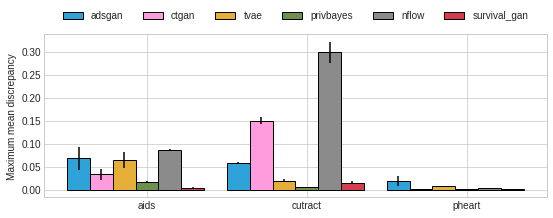

In [9]:
datasets = ["aids", "cutract", "maggic" ]

for title, direction, metrics in [
    ("Maximum mean discrepancy", "minimize", ["stats.max_mean_discrepancy.joint"]),
#     (
#         "Delta precision alpha",
#         "maximize",
#         ["stats.alpha_precision.delta_precision_alpha"],
#     ),
#     ("Delta coverage beta", "maximize", ["stats.alpha_precision.delta_coverage_beta"]),
#     ("Authenticity", "minimize", ["stats.alpha_precision.authenticity"]),
#     # ("Privacy k-anonimization", "maximize",["privacy.k-anonymization.syn"]),
#     # ("Privacy l-diversity", "maximize",["privacy.distinct l-diversity.syn"]),
#     ("Identifiability", "minimize", ["privacy.identifiability_score.score"]),
]:

    plot_performance(datasets, direction=direction, title=title, metrics=metrics)

In [ ]:
# datasets = ["aids", "cutract", "maggic", "seer"]

# det_vals = plot_performance(datasets, direction="maximize", title="test", metrics=[
#              "detection.detection_gmm.mean",
#              "detection.detection_mlp.mean",
#          ])

# det_vals = det_vals.drop(columns = ["str"])

# fontsize = 10
# def plot_detectable(data, datasets):
#     fig, axes = plt.subplots(1, 2 * len(datasets), figsize = (len(datasets) * 5, 3), sharey=True)


#     for idx, dataset in enumerate(datasets):
#         local_data = data[data["dataset"] == dataset]
#         col = idx
        
#         axes[2 * col].tick_params(axis='both', which='major', labelsize=8)
#         axes[2 * col + 1].tick_params(axis='both', which='major', labelsize=8)

#         axes[2 * col].barh(local_data["model"], 1- local_data["mean"], align='center', label = "Not Detectable")
#         axes[2 * col + 1].barh(local_data["model"], local_data["mean"], align='center', color='firebrick', label = "Detectable")
#         axes[2 * col].invert_xaxis()
        
#         axes[2 * col].set_xlabel(f"Dataset:", loc="right", fontsize = fontsize)
#         axes[2 * col].xaxis.set_label_position('top') 

#         pretty_dataset = map_dataset(dataset)
#         axes[2 * col + 1].set_xlabel(f" {pretty_dataset}", loc="left", fontsize = fontsize)
#         axes[2 * col + 1].xaxis.set_label_position('top') 

#     fig.legend(labels = ["Not Detectable", "Detectable"], ncol = 2, loc='center', bbox_to_anchor=[0.5, 1], )
#     #plt.tight_layout()
#     plt.subplots_adjust(wspace=0, hspace=0.2)
#     plt.xticks(fontsize=8)

    
#     plt.savefig(f"diagrams/discrimination_grouped.pdf")
#     plt.savefig(f"diagrams/discrimination_grouped.png")

# plot_detectable(det_vals, ["aids", "cutract", "maggic", "seer"])